In [1]:
from function import *
from data_preparation import *
from evaluation import *

from openpyxl import Workbook
import pandas as pd
import numpy as np
import operator

from rdkit import Chem
from rdkit.Chem import AllChem

# Pre-prepare Data (Data Transformation)

In [2]:
# transform_data(output_file_name='../dataset/keck_complete.csv')

# Analysis

In [3]:
complete_df = pd.read_csv('../dataset/keck_complete.csv')

print complete_df.dtypes

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object


In [4]:
cnt_pria_retest = 0
cnt_pria_fp = 0
cnt_rmi_cdd = 0

cnt_dict = {}
for ix, row in complete_df.iterrows():
    cnt = 0
    if row['Keck_Pria_AS_Retest'] == 1:
        cnt_pria_retest += 1
        cnt += 1
    if row['Keck_Pria_FP_data'] == 1:
        cnt_pria_fp += 1
        cnt += 1
    if row['Keck_RMI_cdd'] == 1:
        cnt_rmi_cdd += 1
        cnt += 1
    if cnt not in cnt_dict.keys():
        cnt_dict[cnt] = 0
    cnt_dict[cnt] += 1

print 'pria retest active: {}\tpria fp active: {}\trmi cdd active: {}'.format(cnt_pria_retest, cnt_pria_fp, cnt_rmi_cdd)
print cnt_dict


print
analysis(complete_df)

pria retest active: 79	pria fp active: 24	rmi cdd active: 230
{0: 72094, 1: 325, 2: 4}

retest: 0, fp: 0, rmi: 0 	--- 49489
retest: 0, fp: 0, rmi: nan 	--- 22605
retest: 0, fp: 1, rmi: 0 	--- 19
retest: 0, fp: 1, rmi: 1 	--- 3
retest: 1, fp: 0, rmi: 0 	--- 58
retest: 1, fp: 0, rmi: nan 	--- 20
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 0, rmi: 1 	--- 227
retest: 1, fp: 1, rmi: nan 	--- 1


# Split data into k-fold

In [5]:
k = 3
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [6]:
k = 4
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [7]:
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

# Merge data from splitting folds to form training and testing

In [8]:
dtype_list = {'Molecule': np.str,
              'SMILES':np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[:3]
train_pd = read_merged_data(output_file_list[:3])
print output_file_list[3]
test_pd = read_merged_data([output_file_list[4]])

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv']
../dataset/fixed_dataset/fold_5/file_3.csv


In [9]:
print 'This is training set'
analysis(train_pd)
print
print 'This is test set'
analysis(test_pd)

This is training set
retest: 0, fp: 0, rmi: 0 	--- 29693
retest: 0, fp: 0, rmi: nan 	--- 13563
retest: 1, fp: 0, rmi: nan 	--- 12
retest: 0, fp: 1, rmi: 1 	--- 1
retest: 1, fp: 0, rmi: 0 	--- 35
retest: 0, fp: 0, rmi: 1 	--- 136
retest: 0, fp: 1, rmi: 0 	--- 12

This is test set
retest: 0, fp: 0, rmi: 0 	--- 9898
retest: 0, fp: 0, rmi: nan 	--- 4521
retest: 1, fp: 0, rmi: nan 	--- 4
retest: 0, fp: 1, rmi: 1 	--- 1
retest: 1, fp: 0, rmi: 0 	--- 11
retest: 0, fp: 0, rmi: 1 	--- 46
retest: 0, fp: 1, rmi: 0 	--- 4
retest: 1, fp: 1, rmi: nan 	--- 1


# Test feature- and label- extraction

In [10]:
print train_pd.dtypes

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object
(43452, 2)
(14486, 2)


# Test Single Classification with Simple NN

In [11]:
config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
    
X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest'])

cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]

print 'done data preparation'

Using Theano backend.
Using gpu device 0: Tesla K40m (CNMeM is disabled, CuDNN 4004)


(43452, 1)
(14486, 1)
done


In [12]:
print X_t.shape
print y_t.shape
print X_val.shape
print y_val.shape
print X_test.shape
print y_test.shape

(36934, 1024)
(36934, 1)
(6518, 1024)
(6518, 1)
(14486, 1024)
(14486, 1)


In [27]:
from single_task import *


class single_task:
    def __init__(self, config_json_file):
        with open(config_json_file, 'r') as f:
            conf = json.load(f)

        self.conf = conf
        self.input_layer_dimension = 1024
        self.output_layer_dimension = 1

        self.early_stopping_patience = conf['fitting']['early_stopping']['patience']
        self.early_stopping_option = conf['fitting']['early_stopping']['option']

        self.fit_nb_epoch = conf['fitting']['nb_epoch']
        self.fit_batch_size = conf['fitting']['batch_size']
        self.fit_verbose = conf['fitting']['verbose']

        self.compile_loss = conf['compile']['loss']
        self.compile_optimizer_option = conf['compile']['optimizer']['option']
        if self.compile_optimizer_option == 'sgd':
            sgd_lr = conf['compile']['optimizer']['sgd']['lr']
            sgd_momentum = conf['compile']['optimizer']['sgd']['momentum']
            sgd_decay = conf['compile']['optimizer']['sgd']['decay']
            sgd_nestrov = conf['compile']['optimizer']['sgd']['nestrov']
            self.compile_optimizer = SGD(lr=sgd_lr, momentum=sgd_momentum, decay=sgd_decay, nesterov=sgd_nestrov)
        else:
            adam_lr = conf['compile']['optimizer']['adam']['lr']
            adam_beta_1 = conf['compile']['optimizer']['adam']['beta_1']
            adam_beta_2 = conf['compile']['optimizer']['adam']['beta_2']
            adam_epsilon = conf['compile']['optimizer']['adam']['epsilon']
            self.compile_optimizer = Adam(lr=adam_lr, beta_1=adam_beta_1, beta_2=adam_beta_2, epsilon=adam_epsilon)

        self.batch_is_use = conf['batch']['is_use']
        if self.batch_is_use:
            batch_normalizer_epsilon = conf['batch']['epsilon']
            batch_normalizer_mode = conf['batch']['mode']
            batch_normalizer_axis = conf['batch']['axis']
            batch_normalizer_momentum = conf['batch']['momentum']
            batch_normalizer_weights = conf['batch']['weights']
            batch_normalizer_beta_init = conf['batch']['beta_init']
            batch_normalizer_gamma_init = conf['batch']['gamma_init']
            self.batch_normalizer = BatchNormalization(epsilon=batch_normalizer_epsilon,
                                                       mode=batch_normalizer_mode,
                                                       axis=batch_normalizer_axis,
                                                       momentum=batch_normalizer_momentum,
                                                       weights=batch_normalizer_weights,
                                                       beta_init=batch_normalizer_beta_init,
                                                       gamma_init=batch_normalizer_gamma_init)
        self.EF_ratio_list = conf['enrichment_factor']['ratio_list']

        return

    def setup_model(self):
        model = Sequential()
        if self.batch_is_use:
            batch_normalizer = self.batch_normalizer
        layers = self.conf['layers']
        layer_number = len(layers)
        for i in range(layer_number):
            init = layers[i]['init']
            activation = layers[i]['activation']
            if i == 0:
                hidden_units = int(layers[i]['hidden_units'])
                dropout = float(layers[i]['dropout'])
                model.add(Dense(hidden_units, input_dim=self.input_layer_dimension, init=init, activation=activation))
                model.add(Dropout(dropout))
            elif i == layer_number - 1:
                if self.batch_is_use:
                    model.add(self.batch_normalizer)
                model.add(Dense(self.output_layer_dimension, init=init, activation=activation))
            else:
                hidden_units = int(layers[i]['hidden_units'])
                dropout = float(layers[i]['dropout'])
                model.add(Dense(hidden_units, init=init, activation=activation))
                model.add(Dropout(dropout))

        return model

    def train_and_predict(self,
                          X_train, y_train,
                          X_val, y_val,
                          X_test, y_test,
                          PMTNN_weight_file):
        model = self.setup_model()
        if self.early_stopping_option == 'auc':
            early_stopping = KeckCallBackOnAUC(X_train, y_train, X_val, y_val, patience=self.early_stopping_patience)
            callbacks = [early_stopping]
        elif self.early_stopping_option == 'precision':
            early_stopping = KeckCallBackOnPrecision(X_train, y_train, X_val, y_val,
                                                     patience=self.early_stopping_patience)
            callbacks = [early_stopping]
        else:
            callbacks = []

        model.compile(loss=self.compile_loss, optimizer=self.compile_optimizer)
        model.fit(X_train, y_train,
                  nb_epoch=self.fit_nb_epoch,
                  batch_size=self.fit_batch_size,
                  verbose=self.fit_verbose,
                  validation_data=(X_val, y_val),
                  callbacks=callbacks)
        model.save_weights(PMTNN_weight_file)

        if self.early_stopping_option == 'auc' or self.early_stopping_option == 'precision':
            print 'get best auc or precision'
            model = early_stopping.get_best_model()
        y_pred_on_train = model.predict(X_train)
        y_pred_on_val = model.predict(X_val)
        y_pred_on_test = model.predict(X_test)

        print('train precision: {}'.format(average_precision_score(y_train, y_pred_on_train)))
        print('train roc: {}'.format(roc_auc_score(y_train, y_pred_on_train)))
        print('validation precision: {}'.format(average_precision_score(y_val, y_pred_on_val)))
        print('validation roc: {}'.format(roc_auc_score(y_val, y_pred_on_val)))
        print('test precision: {}'.format(average_precision_score(y_test, y_pred_on_test)))
        print('test roc: {}'.format(roc_auc_score(y_test, y_pred_on_test)))

        for EF_ratio in self.EF_ratio_list:
            n_actives, ef = enrichment_factor(y_test, y_pred_on_test, EF_ratio)
            print('ratio: {}, EF: {},\tactive: {}'.format(EF_ratio, ef, n_actives))

        return

    def predict_with_existing(self,
                              X_train, y_train,
                              X_val, y_val,
                              X_test, y_test,
                              PMTNN_weight_file):
        model = setup_model()
        model.load_weights(PMTNN_weight_file)

        y_pred_on_train = model.predict(X_train)
        y_pred_on_val = model.predict(X_val)
        y_pred_on_test = model.predict(X_test)

        print('train precision: {}'.format(average_precision_score(y_train, y_pred_on_train)))
        print('train auc: {}'.format(roc_auc_score(y_train, y_pred_on_train)))
        print('validation precision: {}'.format(average_precision_score(y_val, y_pred_on_val)))
        print('validation auc: {}'.format(roc_auc_score(y_val, y_pred_on_val)))
        print('test precision: {}'.format(average_precision_score(y_test, y_pred_on_test)))
        print('test auc: {}'.format(roc_auc_score(y_test, y_pred_on_test)))

        return

    def get_EF_score_with_existing_model(self,
                                         X_test, y_test,
                                         file_path, EF_ratio):
        model = setup_model()
        model.load_weights(file_path)
        y_pred_on_test = model.predict(X_test)
        n_actives, ef = enrichment_factor(y_test, y_pred_on_test, EF_ratio)
        print('test precision: {}'.format(average_precision_score(y_test, y_pred_on_test)))
        print('test auc: {}'.format(roc_auc_score(y_test, y_pred_on_test)))
        print('EF: {},\tactive: {}'.format(ef, n_actives))

        return


def enrichment_factor(labels_arr, scores_arr, percentile):
    '''calculate the enrichment factor based on some upper fraction
       of library ordered by docking scores. upper fraction is determined
       by percentile (actually a fraction of value 0.0-1.0)'''
    sample_size = int(labels_arr.shape[0] * percentile)  # determine number mols in subset
    pred = np.sort(scores_arr)[::-1][:sample_size]  # sort the scores list, take top subset from library
    indices = np.argsort(scores_arr, axis=0)[::-1][:sample_size]  # get the index positions for these in library
    n_actives = np.nansum(labels_arr)  # count number of positive labels in library
    n_experimental = np.nansum(labels_arr[indices])  # count number of positive labels in subset
    if n_actives > 0.0:
        ef = float(n_experimental) / n_actives / percentile  # calc EF at percentile
    else:
        ef = 'ND'
    return n_actives, ef

# define custom classes
# following class is used for keras to compute the AUC each epoch
# and do early stoppping based on that
class KeckCallBackOnAUC(keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, patience=0):
        super(keras.callbacks.Callback, self).__init__()
        self.curr_auc = 0
        self.best_auc = 0
        self.counter = 0
        self.patience = patience
        self.best_model = None
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_train_begin(self, logs={}):
        self.nb_epoch = self.params['nb_epoch']
        self.curr_auc = roc_auc_score(self.y_val, self.model.predict(self.X_val))
        self.best_auc = self.curr_auc
        self.best_model = self.model

    def on_epoch_end(self, epoch, logs={}):
        self.curr_auc = roc_auc_score(self.y_val, self.model.predict(self.X_val))
        if self.curr_auc < self.best_auc:
            print 'current: {}\tbest: {}\tsmaller: {}'.format(self.curr_auc,self.best_auc,self.curr_auc<self.best_auc)
            if self.counter >= self.patience:
                self.model.stop_training = True
            else:
                self.counter += 1
        else:
            print 'update best model'
            print 'current: {}\tbest: {}\tsmaller: {}'.format(self.curr_auc,self.best_auc,self.curr_auc<self.best_auc)
            self.counter = 0
            self.best_auc = self.curr_auc
            self.best_model = self.model
        train_auc = roc_auc_score(self.y_train, self.model.predict(self.X_train))
        train_precision = average_precision_score(self.y_train, self.model.predict(self.X_train))
        curr_precision = average_precision_score(self.y_val, self.model.predict(self.X_val))
        print('Epoch %d/%d' % (epoch + 1, self.nb_epoch))
        print('ROC Train: %f ---- ROC Val: %f' % (train_auc, self.curr_auc))
        print('Precision Train: %f ---- Precision Val: %f' % (train_precision, curr_precision))
        print

    def get_best_model(self):
        return self.best_model

    def get_best_auc(self):
        return self.best_auc


# define custom classes
# following class is used for keras to compute the precision each epoch
# and do early stoppping based on that
class KeckCallBackOnPrecision(keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, patience=0):
        super(keras.callbacks.Callback, self).__init__()
        self.curr_precision = 0
        self.best_precision = 0
        self.counter = 0
        self.patience = patience
        self.best_model = None
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_train_begin(self, logs={}):
        self.nb_epoch = self.params['nb_epoch']
        self.curr_precision = average_precision_score(self.y_val, self.model.predict(self.X_val))
        self.best_precision = self.curr_precision
        self.best_model = self.model

    def on_epoch_end(self, epoch, logs={}):
        self.curr_precision = average_precision_score(self.y_val, self.model.predict(self.X_val))
        if self.curr_precision < self.best_precision:
            print 'current: {}\tbest: {}\tsmaller: {}'.format(self.curr_precision,self.best_precision,self.curr_precision<self.best_precision)
            if self.counter >= self.patience:
                self.model.stop_training = True
            else:
                self.counter += 1
        else:
            print 'update best model'
            self.counter = 0
            self.best_precision = self.curr_precision
            self.best_model = copy.deepcopy(self.model)
            
        train_precision = average_precision_score(self.y_train, self.model.predict(self.X_train))
        train_auc = roc_auc_score(self.y_train, self.model.predict(self.X_train))
        curr_auc = roc_auc_score(self.y_val, self.model.predict(self.X_val))
        print('Epoch %d/%d' % (epoch + 1, self.nb_epoch))
        print('Precision Train: %f ---- Precision Val: %f' % (train_precision, self.curr_precision))
        print('ROC Train: %f ---- ROC Val: %f' % (train_auc, curr_auc))
        print 'Best ROC is: {}'.format(self.best_precision)
        print

    def get_best_model(self):
        print 'get best model'
        return self.best_model

    def get_best_precision(self):
        return self.best_precision

PMTNN_weight_file = 'temp.h5'

task = single_task(config_json_file=config_json_file)
task.EF_ratio_list = conf['enrichment_factor']['ratio_list']
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

update best model
Epoch 1/200
Precision Train: 0.002760 ---- Precision Val: 0.001305
ROC Train: 0.712969 ---- ROC Val: 0.596364
Best ROC is: 0.00130467940609

current: 0.00101741557021	best: 0.00130467940609	smaller: True
Epoch 2/200
Precision Train: 0.005747 ---- Precision Val: 0.001017
ROC Train: 0.767141 ---- ROC Val: 0.498431
Best ROC is: 0.00130467940609

current: 0.000983109651566	best: 0.00130467940609	smaller: True
Epoch 3/200
Precision Train: 0.029141 ---- Precision Val: 0.000983
ROC Train: 0.803321 ---- ROC Val: 0.483511
Best ROC is: 0.00130467940609

current: 0.00110245443117	best: 0.00130467940609	smaller: True
Epoch 4/200
Precision Train: 0.074346 ---- Precision Val: 0.001102
ROC Train: 0.879710 ---- ROC Val: 0.540887
Best ROC is: 0.00130467940609

current: 0.00102299847546	best: 0.00130467940609	smaller: True
Epoch 5/200
Precision Train: 0.125846 ---- Precision Val: 0.001023
ROC Train: 0.935082 ---- ROC Val: 0.516796
Best ROC is: 0.00130467940609

current: 0.0012836909013

In [31]:
import copy

a = np.array([1,2,3])
b = copy.deepcopy(a)
print a
print b



a[1] = 10
print a
print b

[1 2 3]
[1 2 3]
[ 1 10  3]
[1 2 3]


# Plot EF and EF-Max graph

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)

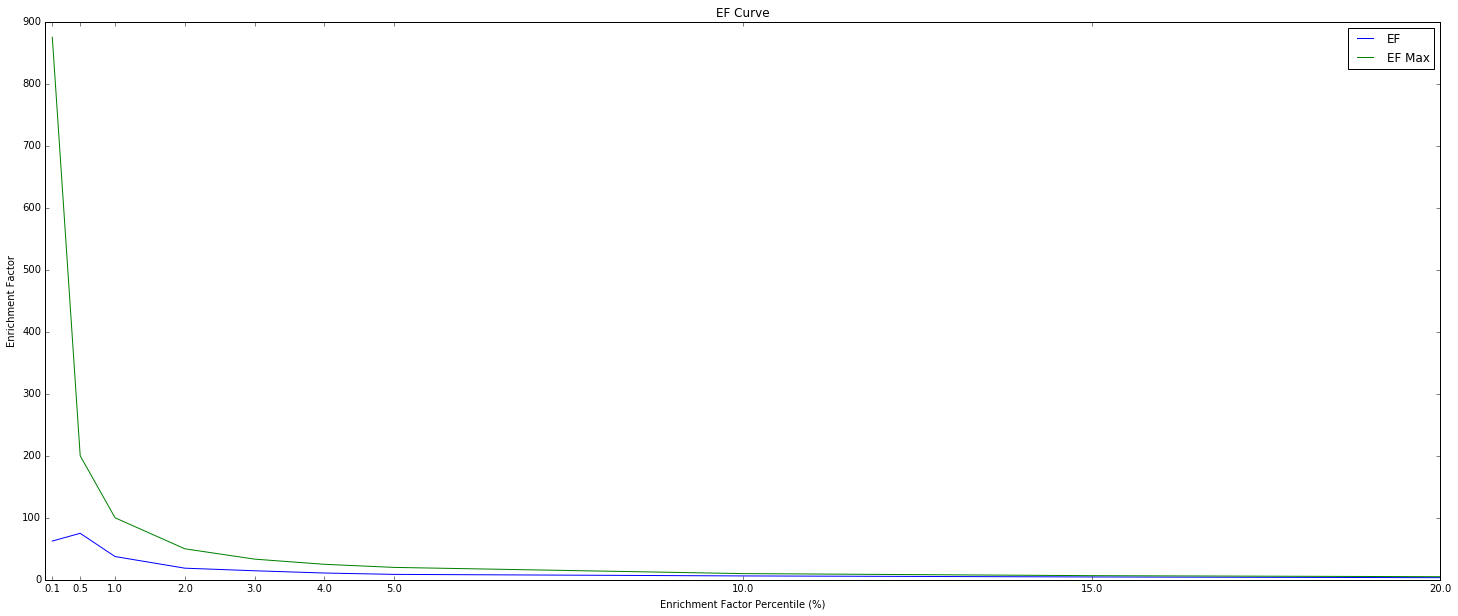

In [15]:
def plot_EF_score_with_existing_model(X_test, y_test, file_path, EF_ratio=0.1):
    model = task.setup_model()
    model.load_weights(file_path)
    y_pred_on_test = model.predict(X_test)
    EF_ratio_list = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 15, 20]
    EF_ratio_list = np.array(EF_ratio_list) / 100.0
    
    ef_values = []
    ef_max_values = []
    for EF_ratio in EF_ratio_list:
        n_actives, ef, ef_max = enrichment_factor_single(y_test, y_pred_on_test, EF_ratio)
        ef_values.append(ef)
        ef_max_values.append(ef_max)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_values)
    plt.plot(x_axis, y_axis)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_max_values)
    plt.plot(x_axis, y_axis)
    
    plt.legend(['EF', 'EF Max'])
    
    plt.xticks(EF_ratio_list, [str(val*100) for val in EF_ratio_list])
    plt.xlabel('Enrichment Factor Percentile (%)')
    plt.ylabel('Enrichment Factor')
    plt.title('EF Curve')
    plt.show()
    return

plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)